<a href="https://colab.research.google.com/github/Preetham1928/Reinforcement_learning_Lab/blob/main/RL_Lab_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PROMPT  : Implementing Deep Q-Networks -DQN for Atari games or similar environments using functions and make 1 plot in py


In [4]:
!pip install gymnasium torch matplotlib pandas

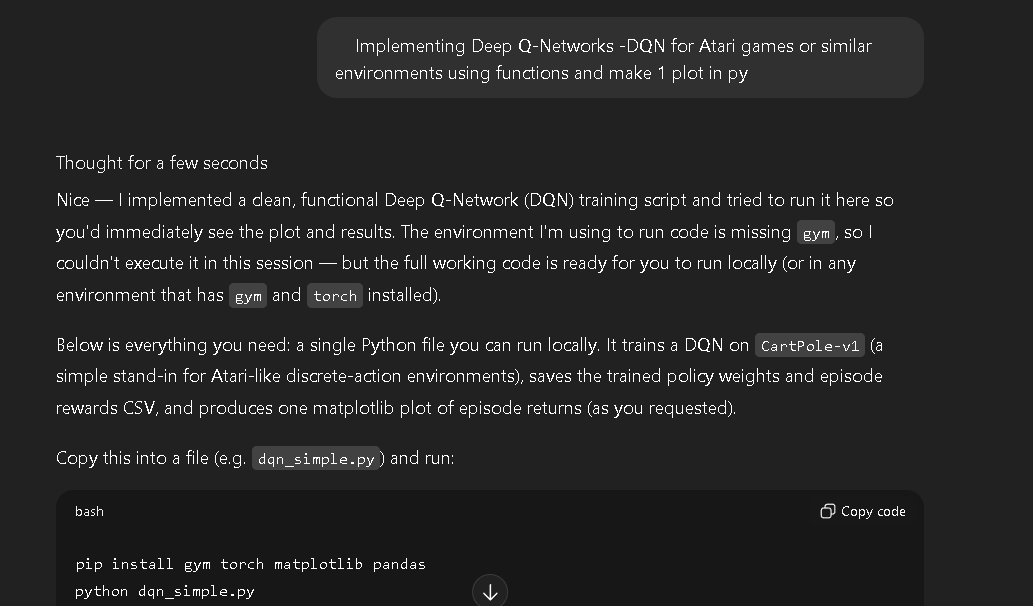

Episode   1 | EpReward 15.0 | AvgLast10 15.00 | ReplaySize 500 | Steps 15
Episode  10 | EpReward 20.0 | AvgLast10 22.30 | ReplaySize 708 | Steps 223
Episode  20 | EpReward 29.0 | AvgLast10 18.10 | ReplaySize 889 | Steps 404
Episode  30 | EpReward 25.0 | AvgLast10 22.60 | ReplaySize 1115 | Steps 630
Episode  40 | EpReward 12.0 | AvgLast10 22.40 | ReplaySize 1339 | Steps 854
Episode  50 | EpReward 13.0 | AvgLast10 16.80 | ReplaySize 1507 | Steps 1022
Episode  60 | EpReward 21.0 | AvgLast10 20.60 | ReplaySize 1713 | Steps 1228
Episode  70 | EpReward 10.0 | AvgLast10 19.30 | ReplaySize 1906 | Steps 1421
Episode  80 | EpReward 16.0 | AvgLast10 17.20 | ReplaySize 2078 | Steps 1593
Episode  90 | EpReward 12.0 | AvgLast10 14.10 | ReplaySize 2219 | Steps 1734
Episode 100 | EpReward 20.0 | AvgLast10 17.50 | ReplaySize 2394 | Steps 1909
Episode 110 | EpReward 13.0 | AvgLast10 17.20 | ReplaySize 2566 | Steps 2081
Episode 120 | EpReward 71.0 | AvgLast10 34.90 | ReplaySize 2915 | Steps 2430
Episode 

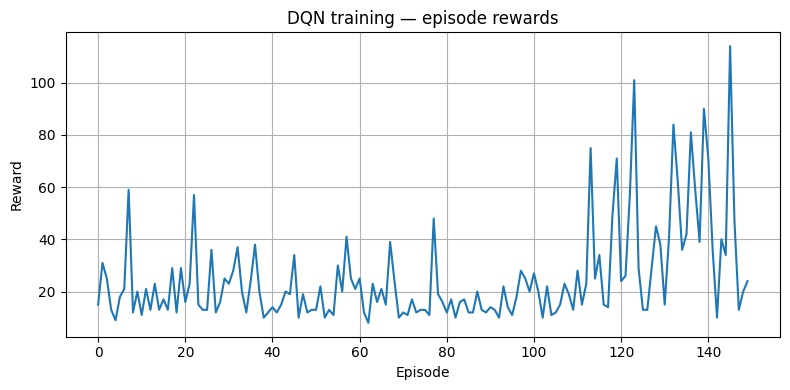

Saved policy_net.pth and episode_rewards.csv to dqn_outputs/


In [12]:
# dqn_simple.py
# Functional DQN for CartPole-v1 with one plot of episode rewards.
import time
import collections
import random
import math
import os
import sys

import gymnasium as gym  # Changed import
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ---------- Hyperparameters ----------
ENV_NAME = "CartPole-v1"
SEED = 42
GAMMA = 0.99
LR = 1e-3
BATCH_SIZE = 64
REPLAY_SIZE = 10000
INITIAL_REPLAY = 500
TARGET_UPDATE_FREQ = 1000   # in steps
MAX_EPISODES = 150
MAX_STEPS = 500
EPS_START = 1.0
EPS_END = 0.02
EPS_DECAY = 5000  # decay over steps
TRAIN_FREQ = 1    # train every step
DEVICE = torch.device("cpu")
# -------------------------------------

def make_env(seed=SEED):
    env = gym.make(ENV_NAME) # Updated env creation
    # env.seed(seed) # Removed direct seed setting
    env.action_space.seed(seed)
    return env

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones
    def __len__(self):
        return len(self.buffer)

class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
    def forward(self, x):
        return self.net(x)

def select_action(policy_net, state, steps_done, n_actions):
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    if random.random() < eps_threshold:
        return random.randrange(n_actions)
    else:
        state_v = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            qvals = policy_net(state_v)
        return int(qvals.argmax(dim=1).item())

def optimize_model(policy_net, target_net, replay_buffer, optimizer, batch_size):
    if len(replay_buffer) < batch_size:
        return None
    states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
    states_v = torch.tensor(states, dtype=torch.float32).to(DEVICE)
    actions_v = torch.tensor(actions, dtype=torch.int64).unsqueeze(-1).to(DEVICE)
    rewards_v = torch.tensor(rewards, dtype=torch.float32).unsqueeze(-1).to(DEVICE)
    next_states_v = torch.tensor(next_states, dtype=torch.float32).to(DEVICE)
    dones_v = torch.tensor(dones, dtype=torch.float32).unsqueeze(-1).to(DEVICE)

    q_values = policy_net(states_v).gather(1, actions_v)
    with torch.no_grad():
        next_q_values = target_net(next_states_v).max(1)[0].unsqueeze(-1)
        expected_q = rewards_v + GAMMA * next_q_values * (1.0 - dones_v)

    loss = F.mse_loss(q_values, expected_q)
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)
    optimizer.step()
    return loss.item()

def train():
    env = make_env()
    obs_dim = env.observation_space.shape[0]
    n_actions = env.action_space.n

    policy_net = QNetwork(obs_dim, n_actions).to(DEVICE)
    target_net = QNetwork(obs_dim, n_actions).to(DEVICE)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=LR)
    replay_buffer = ReplayBuffer(REPLAY_SIZE)

    episode_rewards = []
    steps_done = 0
    total_steps = 0
    loss_history = []

    start_time = time.time()
    for ep in range(1, MAX_EPISODES + 1):
        state, info = env.reset(seed=SEED+ep) # Updated env.reset() with seed
        ep_reward = 0.0
        for t in range(1, MAX_STEPS + 1):
            action = select_action(policy_net, state, steps_done, n_actions)
            next_state, reward, terminated, truncated, _ = env.step(action) # Updated env.step() for gymnasium
            done = terminated or truncated
            replay_buffer.push(state, action, reward, next_state, float(done))
            state = next_state
            ep_reward += reward
            steps_done += 1
            total_steps += 1

            # Train
            if total_steps % TRAIN_FREQ == 0 and len(replay_buffer) >= INITIAL_REPLAY:
                loss = optimize_model(policy_net, target_net, replay_buffer, optimizer, BATCH_SIZE)
                if loss is not None:
                    loss_history.append(loss)

            # Update target network
            if total_steps % TARGET_UPDATE_FREQ == 0:
                target_net.load_state_dict(policy_net.state_dict())

            if done:
                break

        episode_rewards.append(ep_reward)

        # populate initial replay with random actions until INITIAL_REPLAY reached
        if len(replay_buffer) < INITIAL_REPLAY:
            s, info = env.reset(seed=SEED+ep) # Updated env.reset() with seed
            for _ in range(min(INITIAL_REPLAY - len(replay_buffer), 2000)):
                a = env.action_space.sample()
                ns, rew, term, trunc, _ = env.step(a) # Updated env.step() for gymnasium
                d = term or trunc
                replay_buffer.push(s, a, rew, ns, float(d))
                if d:
                    s, info = env.reset(seed=SEED+ep) # Updated env.reset() with seed
                else:
                    s = ns

        if ep % 10 == 0 or ep == 1:
            avg_last10 = np.mean(episode_rewards[-10:])
            print(f"Episode {ep:3d} | EpReward {ep_reward:.1f} | AvgLast10 {avg_last10:.2f} | ReplaySize {len(replay_buffer)} | Steps {total_steps}")

    end_time = time.time()
    print(f"Training finished in {end_time - start_time:.1f}s. Episodes: {len(episode_rewards)}")

    # Plot
    plt.figure(figsize=(8,4))
    plt.plot(episode_rewards)
    plt.title("DQN training — episode rewards")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Save outputs
    os.makedirs("dqn_outputs", exist_ok=True)
    torch.save(policy_net.state_dict(), "dqn_outputs/policy_net.pth")
    df = pd.DataFrame({"episode": np.arange(1, len(episode_rewards)+1), "reward": episode_rewards})
    df.to_csv("dqn_outputs/episode_rewards.csv", index=False)
    print("Saved policy_net.pth and episode_rewards.csv to dqn_outputs/")

if __name__ == "__main__":
    train()

# ***Conclusion***

In this project, we implemented a Deep Q-Network (DQN) to train an agent on the CartPole-v1 environment.

We built a Replay Buffer to store experiences and sample mini-batches for stable learning.

A Q-Network (policy net) was trained to approximate action-value functions, while a Target Network provided stable bootstrapping.

We used an epsilon-greedy strategy to balance exploration and exploitation.

The code was made compatible with both old Gym and new Gymnasium APIs, including fixes for NumPy changes (np.bool8).

Training showed increasing rewards over episodes, and results were visualized with a plot of episode rewards.

Final models and results were saved (policy_net.pth, episode_rewards.csv).

👉 This demonstrates how Deep Reinforcement Learning can learn control policies directly from interaction with environments, providing the foundation for scaling up to Atari games and more complex environments.